# ELEN0016-2 - Computer vision
## Student project - Part 2 : Sudoku digit recognition and performance assessment
### University of Liège - Academic year 2019-2020
### Maxime Meurisse - François Rozet - Océane Rumfels - Valentin Vermeylen

---

## Introduction

### The project

This second part of the project consists of evaluating the performance of our algorithms from project part 1 (line detection) and recognizing digits in a sudoku grid.

More precisely, this part is divided into 4 tasks.

1. First, we recover the annotated lines on Cytomine (soccer, sudoku and road) and compare them with those of our algorithms according to a quantitative comparison criteria in order to evaluate their performance.
2. Second, we need to build a sudoku grid dataset. It should be as varied as possible : digital and handwritten writings, photos from different angles, different writing styles,...
3. Third, we need to train/use several models to detect a sudoku grid and the numbers that make it up.
4. Finally, we must evaluate the performance of the digit recognition algorithms tested.

We would like to thank Professor Van Droogenbroeck and Mr Latour for giving us the opportunity to work on this modified version of the project.

### Work distribution

In general, each member of the group was interested and informed about each task.

However, in order to be more efficient, the work has been distributed.

* **Maxime Meurisse** mainly focused on the first task : he wrote the scripts to retrieve the Cytomine annotations and compare the performance of our project part 1 algorithms.

* **François Rozet** worked on tasks 3 : he wrote the scripts to detect sudoku grids within images and to divide them into individual images of the cells.

* **Océane Rumfels** and **Valentin Vermeylen** focused on tasks 3 and 4 : they tested and trained several models in order to recognize the grid figures and evaluate their performance.

Concerning task 2 (creation of the dataset of annotated sudoku grids), François Rozet wrote a script to *digitally* generate grids and each member of the group took care of printing, annotating and taking pictures of a part of generated grids.

### Code organization

Our code consists of 2 parts : a first part concerning the evaluation of the performance of our line detection algorithms in part 1 of the project (folder `lines/`) and a second part concerning the detection of digits in a sudoku grid (folder `sudoku/`).

The organization of the files, the libraries required and the explanations on how to launch the scripts are explained in the `README.md` file of each folder.

## Performance assessment of line segment detection

This task is divided into two parts : retrieving all annotated and detected segments and evaluating the performance.

### Line segments recovery

We must retrieve the information from the line segments annotated on Cytomine as well as the line segments detected by our algorithm in project part 1.

To do this, we must first define a way to record and store this information. In order to remain consistent with the other parts of this project, we have decided to store it in `.dat` files.

We know that the information to be stored is a line segment defined by its 2 extreme points. Each point is represented by its x and y coordinates. We therefore have 4 numbers to store per segment. We also need the dimensions of each image. These are represented by 2 numbers : width and height.

#### Image dimensions

The dimensions of each image are stored in a `.dat` file (one per image). This file contains the width and height separated by a space character. Its format is therefore the following : `width height`.

> We simply added some python lines in our code from project part 1 to write image dimensions in `.dat` files. In order not to mix the codes, we therefore considered it unnecessary to put the code from project part 1 back into the returned archive. We only provided the `.dat` files.


#### Line segments detected by algorithms of project part 1

Our algorithms of project part 1 using the probabilistic Hough transform, we obtain directly these 4 coordinates. We decided, for each segment of an image, to write the 4 coordinates on the same line, separated by a space character, and in the following order: `x1 y1 x2 y2`. Each segment is written on a new line. The `.dat` file associated with an image therefore has, for example, the following content :

```
32 45 21 67
56 38 23 61
...
```

> We also slightly modified the scripts of project part 1 to do this. Same remark as for image dimensions : only `.dat` files have been added to the archive.

#### Line annotations on Cytomine

To retrieve the annotations from the Cytomine platform, we wrote a python script to connect to it and retrieve the information. On this platform, annotations are expressed in WKT format and can be of different natures (LineString, Polygon, ...). When studying the lines detected on an image, we only consider LineString annotations. All those of different natures are considered erroneous and are not retained.

In theory, each LineString annotation should consist of 4 coordinates (the coordinates of each end point of the segment). However, some of them consist of more than 4 numbers.

Our first idea was to consider these annotations as errors and therefore not to keep them. However, valuable information would have been lost. Subsequently, Mr Latour sent an email providing a CSV file with a list of corrected annotations, taking this problem into account. We then finally decided to use this CSV file to retrieve the Cytomine annotations.

The rest of our project does not concern ellipses, so we only kept the LineString by filtering the Cytomine annotations. It seemed therefore useless to store the information that each annotation is a "LineString".

#### Final database

Our database of annotated and detected segments is therefore composed of `.dat` files (three per image : one containing the Cytomine annotations, one containing the segments detected by our algorithm and one containing the image dimensions) whose structure has been explained previously. These files are stored in the `database/` folder in the `lines/` part of the code.

**Note** : the Cytomine platform uses Cartesian coordinates while the OpenCV python library uses matrix indexes. We therefore applied an affine transformation to the coordinates of the points of the Cytomine segments (after rounding them off because OpenCV work with matrix representation and therefore uses integers only) so that they are in the same convention system as OpenCV :

$$
\begin{align}
    x_{OpenCV} &= x_{Cytomine}\\
    y_{OpenCV} &= height - y_{Cytomine}
\end{align}
$$


### Performance evaluation

Now that our database of `.dat` files containing the annotated and calculated segments is built, we can move on to performance evaluation.

#### A naive method

A very naive qualitative method would be to place Cytomine images and our images side by side and visually compare the detected segments.

The problem being very visual, this method could work but still has major drawbacks : it is very subjective and would take a lot of time if the number of images to compare is high. In addition, the project instructions require that performance be evaluated quantitatively.

#### Distance calculation

A quantitative method therefore seems more appropriate. We then need to define a comparison metric. Our first idea was to play with the distances between each segment and the line passing through these segments. However, this method quickly proved to be tedious for several reasons.

Let's take the case where we would like to calculate the distance of each segment detected by our algorithm to its nearest segment annotated on Cytomine. If our detected segments are a subset of the Cytomine segments, each of our segments will have a near zero distance to an annotated segment and therefore performance will be considered very good. However, being only a subset of the annotated segments, there will be missing segments that have not been found and performance would therefore be actually poor.

If we took the case where the roles were reversed, the problem would be the same. If we have detected more segments than those annotated, they will never be taken into account in a distance calculation (since they will be further than the correct annotated segments) and good performance will be found (when in reality they're actually bad).


#### Confusion matrix

We considered our problem as a classification problem. Indeed, an image can be represented by a set of pixels. Segment detection could therefore consist in classifying each pixel by specifying whether it belongs to a segment or not.

This consideration allows us to use a confusion matrix to assess the performance of our algorithms. The main advantage of this method is that it is a simple and effective way to get an idea of the performance of a classification algorithm. However, there is a drawback in our situation : in the majority of the cases of detection of segments on an image, an error of a few pixels influences little, or not at all, the result and the interpretation that one can make of it (example of a autonomous car which must detect the lines of the road). But a confusion matrix works pixel by pixel. This means that if a segment is correctly detected but shifted by 1 pixel relative to the reference segment, it will be considered as "false" (whereas within 1 pixel, it can reasonably be considered as correct). In an attempt to overcome this problem, we have decided to thicken the segments detected in our images.

So this method would take as input the reference image (that of Cytomine) and our image and would evaluate 4 quantities :

* **True Positive** (TP) : the pixels that we have classified as belonging to a segment and which actually belong to a segment.
* **True Negative** (TN) : the pixels that we have classified as not belonging to a segment and which do not actually belong to a segment.
* **False Positive** (FP) : the pixels that we have classified as belonging to a segment and which do not in fact belong to a segment.
* **False Negative** (FN) : the pixels that we have classified as not belonging to a segment and which actually belong to a segment.
 
In practice, we represent each image by a 2-dimensional array of the same size as the image composed exclusively of 0. Each 0 therefore represents a pixel of the image.

We then traced the lines in these arrays using the `line` function of the OpenCV library. Each pixel belonging to a line has been set to 1. To thicken the lines of our image, we also set to 1 the pixel in the neighborhood of each pixel belonging to a segment.

We finally use the `confusion_matrix` function of the scikit-learn library with our two arrays of 0 and 1 representing our two images (after having flatten them because this function only takes 1-d arrays as input).

We thus obtain a value of the 4 quantities (TP, TN, FP, FN) for each image. Since we have thickened the segments of our images, we have slightly corrected the TN and FP values according to the number of pixels added for thickening.

On the basis of these quantities, several measurements could be calculated. We have chosen 3 of them for each image :

* **recall** : how good our algorithm is at detecting the positives (true segments)

$$
recall = \frac{TP}{TP + FN}
$$

* **specificity** : how good our algorithm is avoiding false alarms (false segments)

$$
specificity = \frac{TN}{TN + FP}
$$

* **precision** : how many of the positively classified (detected segments) were relevant

$$
precision = \frac{TP}{TP + FP}
$$

It is very important to consider and compare several measures rather than just one. Indeed, for example, if we only took the recall measure, an algorithm could very easily cheat on its score by returning only positives. However, in this case it would have a specificity equals to 0; hence the importance of comparing the different measures.

We therefore calculate the average of these measurements of each image in order to have a global idea of the performances of our algorithm on a given class of images. The different results are presented in the following table.

|        | recall | specificity | precision |
| ------ |:------:|:-----------:|:---------:|
| sudoku | 0.9252 |    0.9749   |   0.3023  |
| road   | 0.4471 |    0.9940   |   0.2383  |
| soccer | 0.7064 |    0.9944   |   0.3126  |

First of all, we notice that the specificity of each image class is high : our algorithms do not tend to detect segments that would not be "true" segments. That is a good point. Moreover, in view of these high values, the recall can be interpreted in a non-bombed way.

Secondly, we see that the sudoku has the best recall, then soccer and finally road. So it is our sudoku algorithm that seems to detect the segments best (almost "perfectly"), then our soccer algorithm (properly) and finally our road algorithm (not very good). These results are consistent with the impression we had at the end of the project part 1.

Finally, we find that for each image class, the precision is not very high. This is certainly due to pixel inaccuracies (on reference images, the segmens are straight and sharp whereas with Hough, the segments are in pieces and not always complete). However, by comparing the values relatively to each other, we still notice that the road algorithm, although having a low recall, is very close to other algorithms. This means that the lines he detects are still relevant.

#### Adjacent pixels

In order to try to work around the problem with the confusion matrix explained above (pixels that could be slightly shifted), we had another idea.

This simply consists of browsing pixel by pixel through the binary matrices symbolizing our images and their segments and for each pixel at 1, check if a pixel in a 3x3 area around the corresponding pixel in the matrix of the reference image is also at 1.

However, we realized that this method poses the same problem as the distance method. So we didn't exploit it.

## Creation of the sudoku database

We have chosen the following format for our database : a collection of `png` or `jpg` pictures of sudoku grids, each associated to a `.dat` file containing 9 lines of 9 digits separated by a space character. These digits corresponds to the ones on the grid. An empty cell is marked with the number 0.

In order to build such database, we proceeded in several steps.

### Grid generation

First, François wrote a script to *digitally* generate sudoku grid images and their associated `.dat` file. In order to stick to reality, noise has been added in the form of colored rectangles around the grids.

### Grid annotation

Secondly, since taking the digitally generated images directly would not have constituted a realistic database, we printed 400 grids generated by the script.

We added about ten numbers *by hand* on half of the grids. We then updated the corresponding `.dat` file so that its content remained consistent with the digits in the grid.

Finally, we took pictures of our 400 annotated grids. In order to make the pictures more realistic, we tried to vary the angle of view, lighting, resolution, etc. as much as possible.

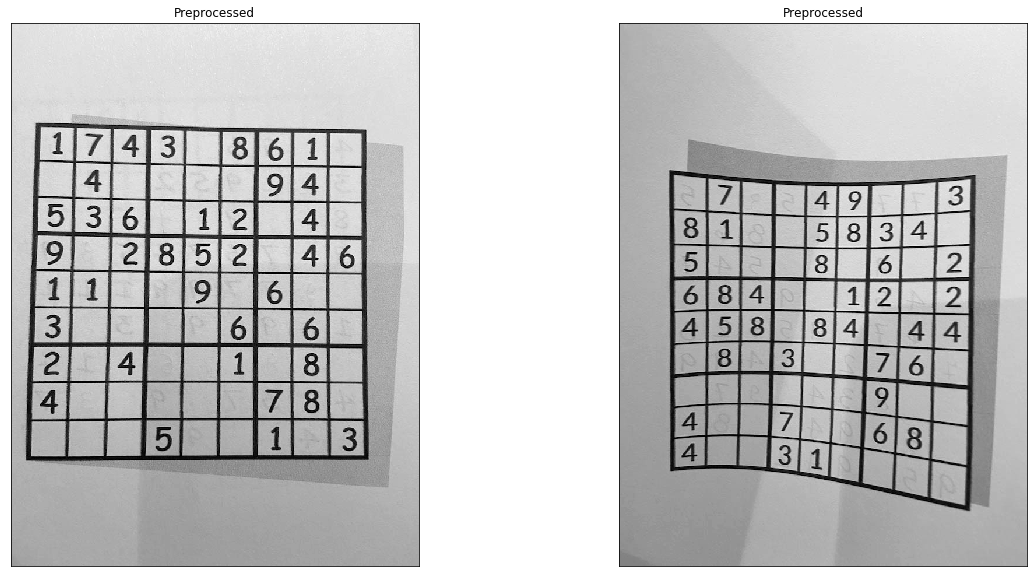

In [2]:
import cv2
import tools

from sudoku import procedure, fast
from models import Ghouzam

model = Ghouzam('../products/models/ghouzam.h5').predict
img_path1 = '../resources/images/annotated/sudoku_0006.jpg'
img_path2 = '../resources/images/annotated/sudoku_0058.jpg'

proc1 = procedure(img_path1, model)
proc2 = procedure(img_path2, model)

next(proc1)
next(proc2)

tools.multi_plot(1, 2, (next(proc1), next(proc2)), ('Preprocessed', 'Preprocessed'), cmap_tuple=("gray", "gray"))

## Digits recognition

The process of recognizing digits has been divided in multiple sub-processes :

1. Grid detection and perspective correction
2. Cell detection, cell placement and cell guessing
3. Digit recognition

### Grid detection

The first step of the grid detection is to perform an *adaptive binary threshold*. Conversely to a *global* one, an adaptive threshold algorithm determines the threshold for a pixel based on a small region around it.

Through trial and error, we found that such threshold was far better suited to the task, especially when the image had different lighting conditions in different areas or when there was a ornament around the grid.

In our implementation, the size of the regions are determined by the image size so that the procedure remains consistent. Also, the regions are fairly small and the threshold quite high which results in removing part of the ornaments but not the grid outer edges.

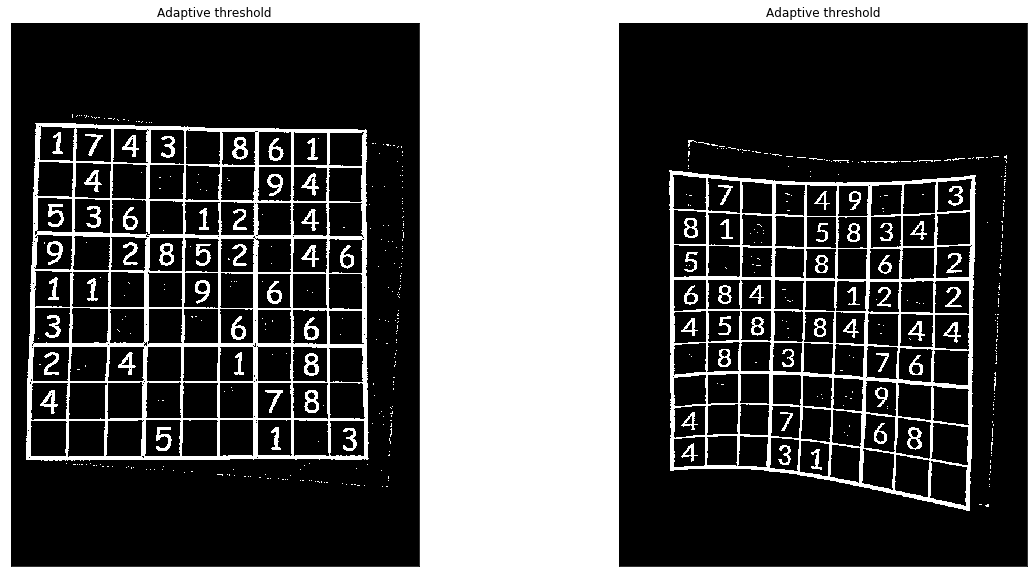

In [3]:
tools.multi_plot(1, 2, (next(proc1), next(proc2)), ('Adaptive threshold', 'Adaptive threshold'), cmap_tuple=("gray", "gray"))

After that threshold, the outer contour of the grid should standout a lot more. To detect its position, we apply a *contour finding* procedure. Since the one implemented in the OpenCV library is quite efficient and works really well, we used it.

> The OpenCV `findContours` function is implemented according to a *Border Following* algorithm proposed by Satoshi Suzuki and Keiichi Abe in 1983 (c.f. References section). This algorithm is still at the state of the art nowadays.

However, this function finds *all* the contours (and holes) in the image. Therefore, we filter the produced list of contours to keep only the largest one whose minium area enclosing rectangle (`minAreaRect` function in OpenCV) is more or less (up to a threshold) a square.

$$
\left|1 - \frac{width}{height}\right| \leq threshold
$$

Then, from the selected contour, we retrieve its most northeast, northwest, southwest and southeast points and define them as the grid corners.

> This makes the assumption that the grid isn't rotated more than $\frac{\pi}{4}$ radians in either direction. Yet, this isn't too big of an assumption.

Finally, the perspective is determined from the corners position (`getPerspectiveTransform` function in OpenCV) and is corrected (`warpPerspective` function in OpenCV). The result is most of the time a nice straight flat grid.

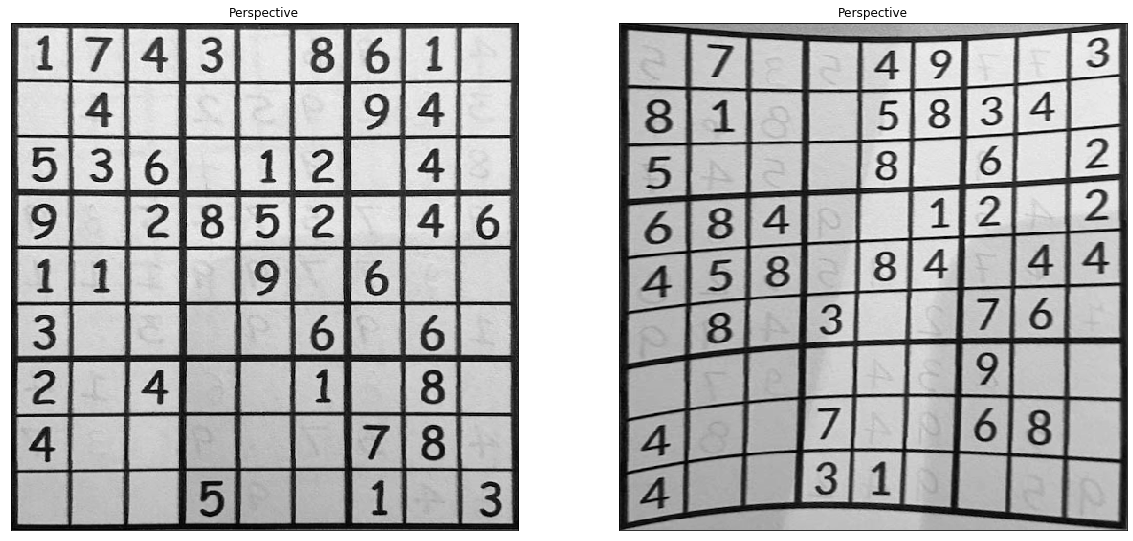

In [4]:
tools.multi_plot(1, 2, (next(proc1), next(proc2)), ('Perspective', 'Perspective'), cmap_tuple=("gray", "gray"))

### Cell detection

After the perspective has been corrected, we need to extract each cell individually to feed our digit recognition model(s). The first step is, again, to apply an adaptive threshold to the image. However, this time the region considered are larger and the threshold is lower which allows to pick up the thinner lines of the grid as well.

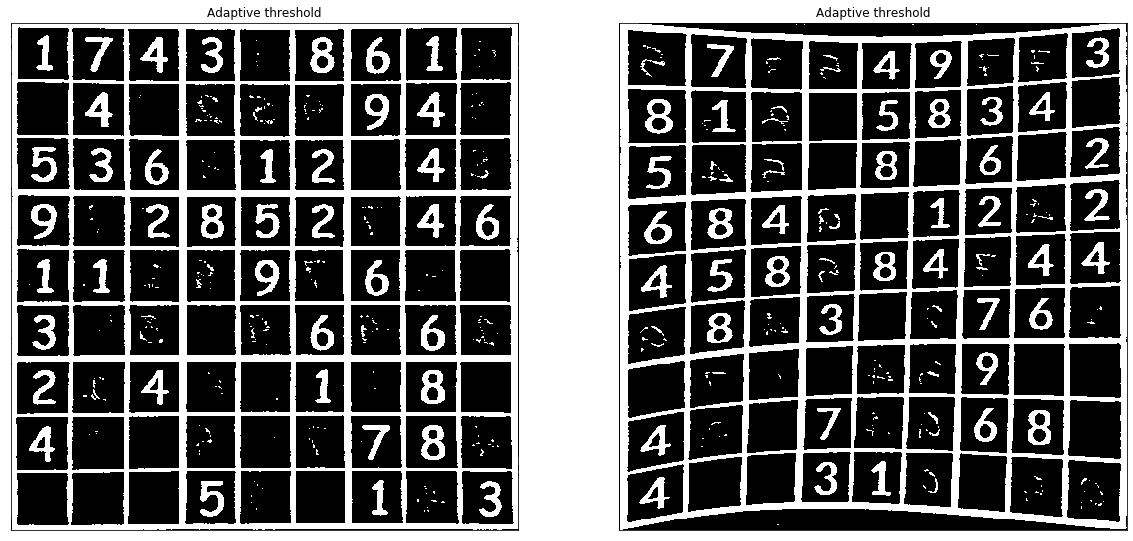

In [5]:
tools.multi_plot(1, 2, (next(proc1), next(proc2)), ('Adaptive threshold', 'Adaptive threshold'), cmap_tuple=("gray", "gray"))

Then, a new contour finding procedure is applied whose goal is to discriminate and remove the shapes that are too small to be cells, i.e. mostly digits and noise. However, we tried to keep small pieces of straight lines since they most likely belong to the grid.

$$
area \leq threshold \quad \text{and} \quad area \geq \frac{perimeter}{2}
$$

Thanks to this cleaning, it is now possible to apply a strong *dilation* (`dilate` function in OpenCV) in every direction without worrying about smaller shapes merging with the grid.

Then, a second contour finding procedure is applied but with the goal to detect cells this time.

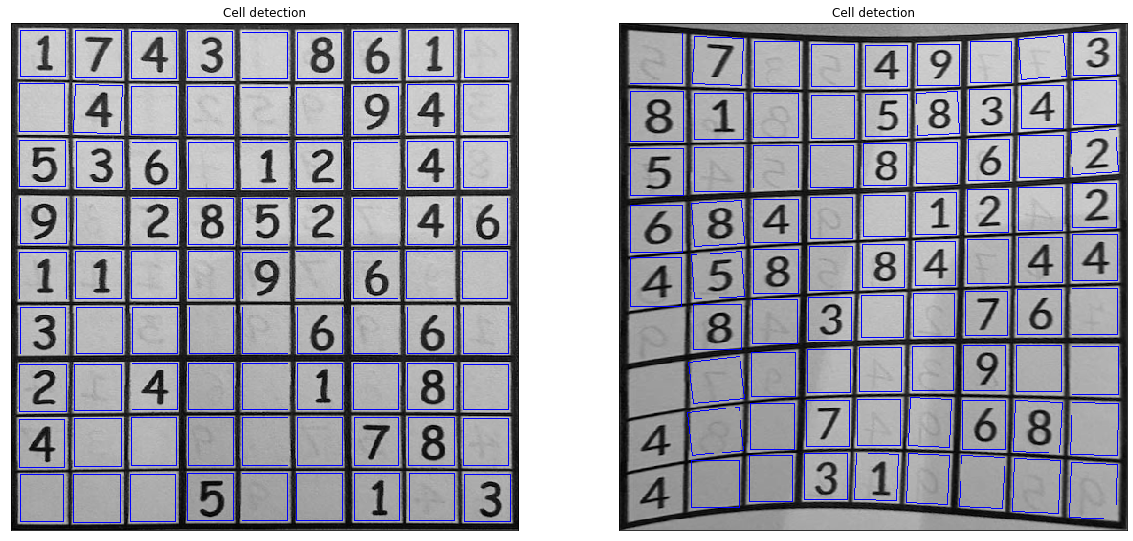

In [6]:
tools.multi_plot(1, 2, (next(proc1), next(proc2)), ('Cell detection', 'Cell detection'), cmap_tuple=("gray", "gray"))

Unfortunately, it is not possible to map directly each detected cell to a 9 by 9 array. Indeed, the contours returned by `findContours` aren't necessarily in any precise order and, most of the time, a few cells are missing or in excess.

Therefore the next step is to determine each cell location with respect to the grid, guess missing ones' location and size and remove outliers.

The routine we designed to complete this task won't be explained in this report since it is quite calculoïd and not actually linked to the Computer Vision field. However, one should note that it needs *at least* one cell in each line and column of the grid to work correctly.

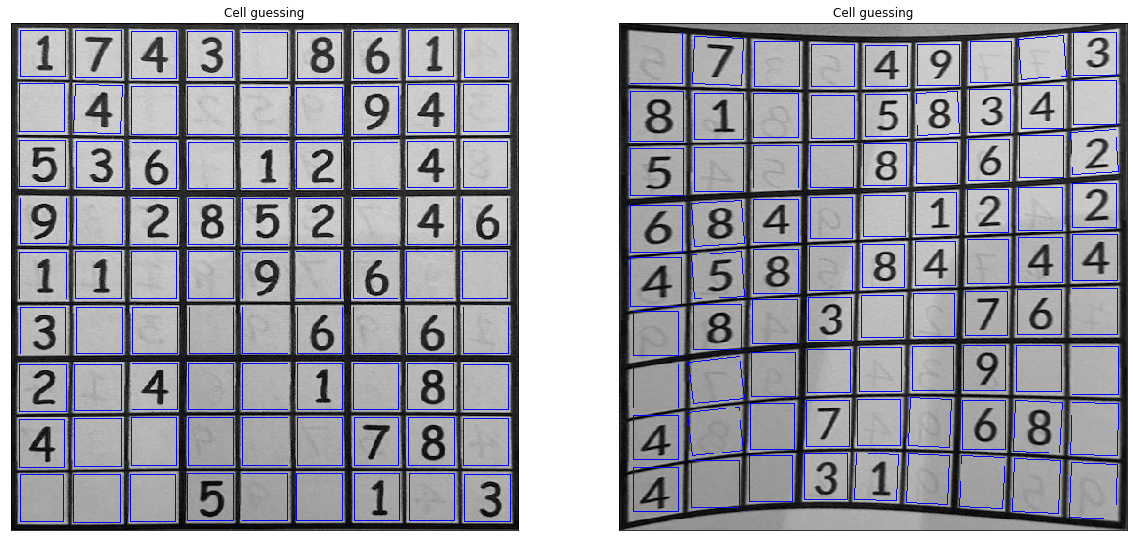

In [7]:
tools.multi_plot(1, 2, (next(proc1), next(proc2)), ('Cell guessing', 'Cell guessing'))

### Digit recognition

After the cell detection, cells of an image are passed one by one to our digit recognition subroutine. These cells being very similar to the MNIST dataset, we decided to look for models based on it to detect our digits. We tried several models as tutorials are plentiful on the Internet, each providing their own small networks. However, they did not provide good results. We then found a [notebook](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6) on a Kaggle digit recognition competition that nicely described its network and provided very good results. It is a 5-layers Sequential Convolutional Neural Network, and the explanation concerning its architecture given hereafter is taken for the biggest part from the notebook.

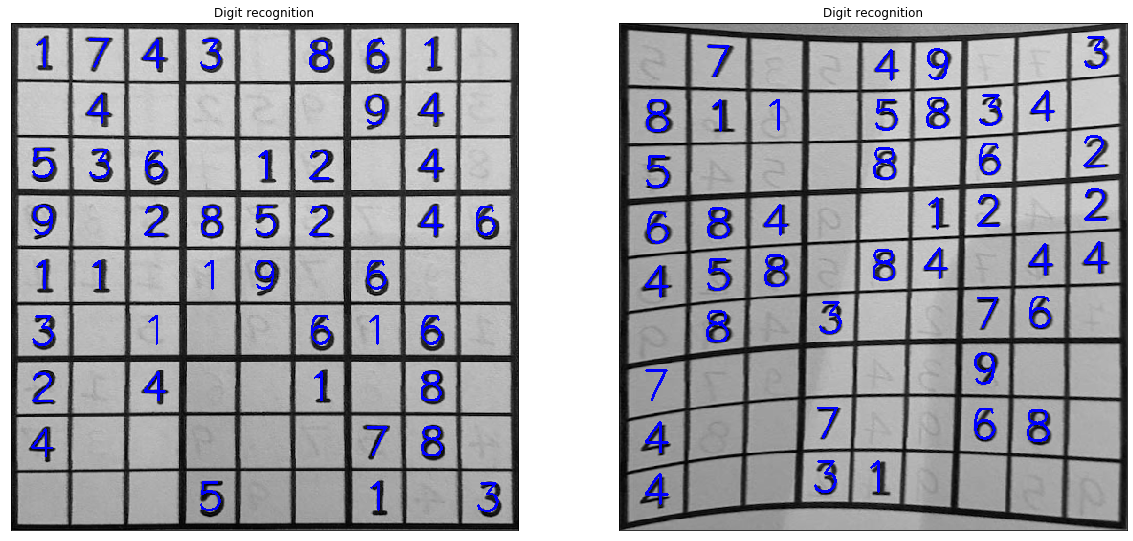

In [8]:
tools.multi_plot(1, 2, (next(proc1), next(proc2)), ('Digit recognition', 'Digit recognition'))

In [9]:
fast(img_path1, model)

array([[1, 7, 4, 3, 0, 8, 6, 1, 0],
       [0, 4, 0, 0, 0, 0, 9, 4, 0],
       [5, 3, 6, 0, 1, 2, 0, 4, 0],
       [9, 0, 2, 8, 5, 2, 0, 4, 6],
       [1, 1, 0, 1, 9, 0, 6, 0, 0],
       [3, 0, 1, 0, 0, 6, 1, 6, 0],
       [2, 0, 4, 0, 0, 1, 0, 8, 0],
       [4, 0, 0, 0, 0, 0, 7, 8, 0],
       [0, 0, 0, 5, 0, 0, 1, 0, 3]])


#### How the network works

In order to **train** the network, the first thing we did was acquire the **data** from the mnist dataset. After that, we performed a greyscale normalization on it. The source from which we have taken this network tells us that doing so reduces the effect of difference in illumination and, as we tested with and without normalization, we realized that performances were indeed increased with a normalization. The next step was to reshape our training and testing data to comply with the input dimension of the network we wanted to design. The labels were then encoded in one-hot vectors. In our implementation, the test data coming from mnist became our validation data while our test samples was the sudoku dataset we had build.

Once we had the data, we **defined the model**. The first two layers are convolutional ones. The first one takes the full *28x28* image as input and has 32 output filters. The second one takes these outputs as inputs and has the same dimensionality for its output.
Each convolution layer acts as a filter and detects specific features in the input element and returns a particular feature map.

After that, a pooling layers was added to the model. Pooling layers are useful to reduce the number of parameters and the computation in the network. It accomplished that by down-sampling the feature maps created by the different convolutionnal layers. In our case, we selected a pooling layer `MaxPool2D` to apply to the second outputed map, and a size of pooling operation of *2x2* (halving of the input in both dimensions). Within this portion, the maximum value will be calculated and will represent the whole batch in the down-sampled output. By combining convolutional layers and pooling ones, the network is able to combine local features in order to learn more global features of the input.

A dropout layer was then added to the network. Such layers are used to generalize the model and prevent it from overfitting. They randomly set the weight of some neurons to zero (a proportion of 25% in our network). Doing this ensures that the network will learn features in a more distributed way (not only one neuron/one route in the network will be responsible for detecting feature x).

The whole block presented above is then repeated directly after.

Then a Flatten layer is used to convert the final feature map into a 1D vector, which is the shape we desire.

Finally, two fully-connected Dense layers were used and the final output is the probability estimated for each one of the 10 classes (0 to 9).


Once the model was defined, we had to **set the optimizer and the annealer**. The optimizer is the function that is in charge of improving the parameters in order to minimize the loss function (cross-entropy for categorization in our case). The chosen optimizer is called *RMSprop*. The metrics used to evaluate the model is the accuracy. To make the optimizer converge faster and closer to the global minimum of the loss function, the author used an annealing method of the learning rate (LR), reducing it dynamically to improve the convergence towards the global minimum.

The next idea implemented by the author was to use **data augmentation** of the learning set, which helps reducing the overfitting and provides better performance. The transformations that were permitted for the data augmentation were rotations of the images by 10°, zooms by 10%, shifting horizontally by 10% of the width and vertically by 10% of the height.

After these steps, we had to **fit the model**, and we chose a batch size of 86 and a number of epochs of 10. The author advises to use 30 for the number of epochs, but we tested and this provided slightly worse performance on our problem, probably because some overfitting was achieved for the mnist dataset or because it was worse on non-handwritten digits.

**Other models** based on a Sequential Convolutional Neural Network were also tested, such as *mlm* and *gkoehler*, but they did not perform as well as the *ghouzam* one. Their implementation is provided in our code, as well as the resulting models. A small discussion about their performances is provided in the next section.

Other types of models were also tested : VGG16, MobileNet and ResNet164, the three of them coming from this website :https://github.com/Curt-Park/handwritten_digit_recognition where the models can be downloaded (these are very voluminous files). Explanations on the models are available in the appendix.

In order for the images to be passed as inputs to these models, sometime some modifications were necessary such as reshaping to images of dimension (1, 28, 28, 1) or (-1, 28, 28, 1), or normalization of the images. Furthermore, to improve the accuracy, a threshold was applied to the cell before the prediction process.

## Performance assessment of digits recognition

Each generated sudoku grid has an associated `.dat` file. Our digit recognition algorithms write a `.dat` file with their prediction of the grid content.

The content of these `.dat` files being of the same form, it is very simple for us to compare them. We have defined several comparison metrics. First, we have the overall accuracy, *i.e.* the proportion of cells that are correctly identified, then we have the non-empty accuracy, which is the same metrics but which does not take the empty cells into account (only if they are empty in the ground truth AND in the predicted output). Finally, we also investigated the first metric via its confusion matrix. The **rows** represent the **ground truth** and the **columns** the **predictions** provided by our model.  Those elements can be obtained via the *perf.py* script. 

For our *Ghouzam* model, we have the following results : 
* Accuracy with empty cells : 0.976
* Accuracy without empty cells : 0.957
* Confusion matrix with empty cells : 

|       |   0   |  1   |  2   |  3   |  4   |  5   |  6   |  7   |  8   |  9   |
| ----- |:-----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
| **0** | 13923 | 146  |  18  |  9   |  7   |  49  |  8   |  35  |  5   |  16  |
| **1** |  40   | 1773 |  10  |  3   |  36  |  0   |  0   |  87  |  1   |  10  |
| **2** |   6   |  1   | 1929 |  2   |  4   |  1   |  0   |  2   |  11  |  4   |
| **3** |   6   |  1   |  1   | 1914 |  3   |  3   |  2   |  1   |  1   |  0   |
| **4** |  21   |  2   |  2   |  0   | 1895 |  3   |  3   |  3   |  6   |  27  |
| **5** |   7   |  1   |  0   |  2   |  3   | 1882 |  0   |  1   |  1   |  2   |
| **6** |  10   |  3   |  2   |  2   |  5   |  5   | 1892 |  0   |  2   |  1   |
| **7** |   6   |  1   |  9   |  3   |  26  |  1   |  1   | 1857 |  2   |  2   |
| **8** |   4   |  3   |  1   |  1   |  3   |  2   |  1   |  3   | 1945 |  1   |
| **9** |  12   |  0   |  4   |  1   |  6   |  12  |  0   |  3   |  3   | 1826 |


We can note that the number one is sometime casted as a seven or a four, and in general was less well identified than the other numbers. This confusion can be explained by the fact that in the mnist dataset, the number one is most of the time represented by a single vertical line and not the 'angled' shape similar to a four or a seven. The number seven, on the other hand, rarely has the horizontal line in the middle we are used to seeing in Belgium. They resemble more a 1.
The number zero also induced a lot of perplexity. Indeed, in the sudoku case, the '0' digit is not represented while it is in the mnist data-set. Thus the model sometimes had troubles to interpret the blank image it was given. Furthermore, noise on the empty cells could easily trick the network into thinking a number is present. Indeed, as a straight line is understood as a 1, the effect of a border, some random noise or the surimpression of a number coming from the verso of the page could are all examples where the network may think the cell is containing a 1 (or something else). Testing with image "29" shows well these elements.
However, the model seems to recognized a very important part of the digits (more than 95%, and more than 97% if we take the empty cells into account). Testing with image "105" shows the good results of our algorithm even with a not so perfect image. If we aggregate the columns of the confusion matrix to see what is the accuracy per digit, we get the following table (transposed for a question of space) : 

| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
| - | - | - | - | - | - | - | - | - | - |
| 0.979 | 0.905 | 0.984 | 0.991 | 0.966 | 0.991 | 0.984 | 0.973 | 0.990 | 0.978 |

We also had a look at what happened only for handwritten digits (without taking into account digital numbers). We reached a (non-empty cells) accuracy of 88.5%, and the aggregated confusion matrix is : 

| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
| - | - | - | - | - | - | - | - | - | - |
| 0.979 | 0.905 | 0.984 | 0.991 | 0.966 | 0.991 | 0.984 | 0.973 | 0.990 | 0.978 |

We also had a look at what happened only for handwritten digits (without taking into account digital numbers). We reached a (non-empty cells) accuracy of 88.5%, and the aggregated confusion matrix is : 

| 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |
| - | - | - | - | - | - | - | - | - |
| 0.615| 0.892| 0.973| 0.878 | 0.981 | 0.978 | 0.837 | 0.981 | 0.891 |

As can be seen, the worst performance comes from the 1, which are often confused with 4, 7 and "0". 4 are also sometimes confused with 9, and 7 with 4. However, when investigating the cells, some were hard to distinguish, even for the human eye.

**Resnet**
For our *resnet* model, the different metrics are the following : 
* Accuracy with empty cells : 0.692
* Accuracy without empty cells : 0.442

The confusion is not reported here due to a lack of space, but we can observe that the network predicts the number 0 more often than not. This is due to the fact that we have put a threshold on the probabilities predicted. Indeed, if the maximum probability is less than 0.55, we say that the case is empty, which is not true in practice. However, reducing that threshold provides even worse results as more cells are wrongly identified (we discovered that most empty cells were then predicted as containing a 1).
The network is very uncertain, as many grids contain less than half of their digits once the overlay is performed (which means than only these digits do not have the value 0). This means that the network makes a lot of low-confidence predictions.

One consideration we can make is also that resnet was not trained with empty cells. Every training sample contained a digit, while we pass some empty cells. In *Ghouzam*, we solved that problem with the probability thresholding, but it does not work here. A way to overcome that could be to first detect if a cell contains a digit or not, then to pass it to *resnet* if it does not, and to not make any probability thresholding, or even to retrain the network by adding empty cells to the MNIST dataset, and using another label than 0 for these ones. After trial of the "filtering" idea, we found out that more digits were identified, but many were wrongly classified, leading to performances worse than *ghouzam*, and a much longer processing time.

The evaluation of some other networks we tested are given in the appendix.

## Conclusion

This project allowed us to explore two main areas : the evaluation of algorithms performance and the application of machine learning to digit recognition in images.

Concerning performance evaluation, it is first necessary to define an evaluation metric, which is far from being an easy task : it must be applicable to the problem studied and relevant. In our case, we finally opted for a confusion matrix.

It is then necessary to define the different scores that can be computed according to the chosen metric. Indeed, each score does not have the same meaning, and the same score can be very good in one case and very bad in another. It is therefore very important to compare and discuss them. The same algorithm rarely has a maximum rating for all scores. This does not mean that it is bad. In our case, we opted for the recall, the specificity and the precision.

Regarding the use of machine learning for number recognition in a sudoku grid, we were surprised at the difficulty of the problem. Indeed, the recognition of numbers is not as easy as it seems : although many models already exist on this subject, they are not always suitable for our specific application and the ones provided on the Internet were rarely as efficient as we would have liked.

In the end, the *ghouzam* model was selected because of his superior accuracy but also because it was faster than more complex models.

## References

The references consulted for the realization of this project are listed below.

* [Performance Evaluation of Different Line Detection Algorithms](http://www.ijmo.org/papers/152-S014.pdf)
* [Confusion matrix - Wikipédia](https://en.wikipedia.org/wiki/Confusion_matrix)
* [Confusion matrix - Scikit-learn (documentation)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
* [Confusion matrix - Scikit-learn (implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
* [Precision and recall - Wikipédia](https://en.wikipedia.org/wiki/Precision_and_recall)
* [Precision, recall, sensitivity and specificity](https://uberpython.wordpress.com/2012/01/01/precision-recall-sensitivity-and-specificity/)
* [OpenCV - Image Thresholding](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html)
* [OpenCV - Eroding and Dilating](https://docs.opencv.org/2.4/doc/tutorials/imgproc/erosion_dilatation/erosion_dilatation.html)
* [OpenCV - Geometric Image Transformations](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html)
* [OpenCV - Contours](https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html)
* [Satoshi Suzuki and Keiichi Abe - Topological structural analysis of digitized binary images by border following (1983)](https://www.sciencedirect.com/science/article/abs/pii/0734189X85900167)
* [Yassine Ghouzam - Introduction to CNN Keras](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
* [Keras - core layers](https://keras.io/layers/core/)
* [Gkoehler model](https://nextjournal.com/gkoehler/digit-recognition-with-keras)
* [mlm model](https://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/)
* [Resnet model](https://github.com/Curt-Park/handwritten_digit_recognition)
* [MobileNet - Depth-wise separable convolutions](https://machinethink.net/blog/googles-mobile-net-architecture-on-iphone/)

## Appendix

### VGG16

Using the same type of layers as for a Sequential model, VGG16 has a very particular structure. It is made of *3x3* convutionnal layers decreasing in sizes, thanks to pooling layers, followed by two fully-connected layers, and finally a softmax classifier.

### ResNet

ResNet or residual network, involves skip connection. This means that, through this connection, an activation function can access the input of a layer. In the other types of networks, this input has to go through weights and sometime several layers. With this, the output of a block will not be only the features extracted but a sum of the original input and its detected features. This limits the phenomenon called "vanishing gradients". Vanishing gradients occurs when an input change induces a small output change, if the change is minor, the model has troubles to learn from it. It can be caused by the activation function which stacks too much, or the multiple layers mapping each region into even small regions, thus decreasing the change.

### MobileNet

MobileNet is a network that implements depth-wise separable convolution. Normal convolution takes several inputs channels, for example an image of dimension (249, 249, 3) of 3 channels, and write only one output to summarize the results of the three channels.
MobileNet implements a output channel for each input channel, to filter each input channel. Filtering input channels is interesting for many application like edge detection, color filtering, etc.

### Evaluation for other models

For our *gkoehler* model, we reached an overall accuracy of 0.89 and a non-empty cells accuracy of 0.8. Its confusion matrix is not reported here but we can see on it that the model confuses a 1 for a 7 30% of the time, which is worse than *ghouzam*. However, a 7 was not once confused with a 1. The rest of the matrix is similar to the one presented above, although worse overall.

For our *mlm* model, we reached an overall accuracy 94% and a non-empty cell accuracy of 92%. Ones are also quite often mistaken as 7.


For the *VGG16* and *MobileNet* model, the respective overall accuracies are 0.33 0.455 while the non-empty cell accuracies are 0.32 and 0.026. There are a few reasons that could explain this bad performance. In both confusion matrices we can observe a strange behaviour : a large amount of digits was identified as ones or zeros. There was even more confusion between one and zero as more zeros were casted as ones than zeros. This could be an extreme consequence of the two phenomenons explained previously (the shape of the ones and empty cells instead of written zeros).
Furthermore, the training process done by the author to obtain theses models contains a few particular elements.
First of all, he normalizes all the mnist images in a very specific way. The same normalization applied to our dataset produced results even worse as, this time, only ones were identified.
Then, he also generated his own images, Transforming the mnist data-set into a much bigger different dataset.
Moreover, his models are modified versions of the original ones and several layers were added. As explained before, layers shape the behaviour of a model, thus adding layers can really alter the performance of the algorithm.
